This is an example notebook, which will go through an example of predicting categorical variables. Following along with the documentation might also prove to be helpful.
https://abcd-ml.readthedocs.io/en/latest/ABCD_ML_class_docs.html

# Init Phase

In [1]:
import ABCD_ML

# We will use a few extra libraries during this example
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Just defining all of the locations of data to be used at the start
base_dr = '/mnt/sdb2/'

data_dr = os.path.join(base_dr, 'ABCDFixRelease2p0p1')
rest_dr = os.path.join(base_dr, 'ABCD2p0NDA')

struc1 = os.path.join(data_dr, 'abcd_mrisdp101.txt')
struc2 = os.path.join(data_dr, 'abcd_mrisdp201.txt')

mid1 = os.path.join(data_dr, 'abcd_midabwdp01.txt')
mid2 = os.path.join(data_dr, 'abcd_midabwdp202.txt')

sst1 = os.path.join(data_dr, 'abcd_tfsstabwdp101.txt')
sst2 = os.path.join(data_dr, 'abcd_tfsstabwdp201.txt')

nback1 = os.path.join(data_dr, 'abcd_tfabwdp101.txt')
nback2 = os.path.join(data_dr, 'abcd_tfabwdp201.txt')

rs1 = os.path.join(data_dr, 'abcd_betnet02.txt')

target1 = os.path.join(rest_dr, 'abcd_mri01.txt')

name_map_loc = os.path.join(data_dr, 'Fix Release Notes 2.0.1_Public',
                            '24. ABCD_Release_2.0.1_Updates', 'abcd_2.0.1_mapping.csv')

In [3]:
ML = ABCD_ML.ABCD_ML(exp_name = 'Site',
                     log_dr = '',
                     existing_log = 'overwrite',
                     verbose = True,
                     notebook = True,
                     use_abcd_subject_ids = True,
                     low_memory_mode = False,
                     random_state = 1)

exp_name = Site
log_dr = /home/sage/ABCD_ML/Examples
existing_log = overwrite
verbose = True
exp log dr setup at: /home/sage/ABCD_ML/Examples/Site
log file at: /home/sage/ABCD_ML/Examples/Site/logs.txt
notebook = True
use_abcd_subject_ids = True
low memory mode = False
strat_u_name = _Strat
random state = 1
ABCD_ML object initialized


# Loading Phase

First we will define any default loading params to be used during the loading phase. Of note is that we will note be dropping missing subjects.

In [4]:
ML.Set_Default_Load_Params(dataset_type = 'default',
                           subject_id = 'src_subject_id',
                           eventname = 'baseline_year_1_arm_1',
                           eventname_col = 'eventname',
                           overlap_subjects = False,
                           drop_na = False)

No default dataset_type passed, set to "basic"
No default na_values passed, set to ["777", "999"]
No default drop_or_na passed, set to "drop"
Default load params set within self.default_load_params.



Next, we will load a name mapping, which is simply saying, upon loading any data, if possible convert from the nda_name used to the deap_name. Nothing too fancy, but if there is a naming scheme one prefers...

In [5]:
ML.Load_Name_Map(loc = name_map_loc,
                 dataset_type = 'explorer',
                 source_name_col = 'nda_name',
                 target_name_col = 'deap_name')

Loading /mnt/sdb2/ABCDFixRelease2p0p1/Fix Release Notes 2.0.1_Public/24. ABCD_Release_2.0.1_Updates/abcd_2.0.1_mapping.csv  with dataset type: explorer
Loading new name_map from file!


Following the roughly reccomended Loading order, we would load either Exclusions or Inclusions. With Load_Exclusions(), and Load_Inclusions(), respectively. We will skip those steps here.

When loading data (and covars ect...) it can be useful to set clear_existing to True if you are playing around with different settings. clear_existing = True, will clear any loaded data, whereas by default it is normally set to False, allowing the user to call Load_Data multiple times in order to load data from multiple sources.

Normally, with clear_existing=True, the user can just keep reloading the same notebook cell with different settings if desired, but for the purpose of an example, we will keep old runs.

A few other things to note, we pass loc = [data1, data2], which lets us load data from two locations at the same time. Because they are the same dataset type, we can just leave dataset_type as 'default' (which will default to the default value we set earlier), but if for example data2 was explorer type, we could pass dataset_type = ['default', 'explorer'].

For the rest of the parameters, we will begin very conservatively.

In [6]:
ML.Load_Data(loc = [struc1, struc2], 
             drop_keys = [],
             filter_outlier_percent = None,
             clear_existing = True)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 0 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Loaded rows with NaN remaining: 2892

Processing unique col values with drop threshold: 0 - warn threshold: 576.7 - out of 11534 rows
Warn - smri_area_cort.destrieux_g.cingul.post.ventral.lh has unique vals: 495
Warn - smri_area_cort.destrieux_g.front.inf.orbital.lh has unique vals: 312
Warn - smri_area_cort.destrieux_g.ins.lg

A lot of diagnostic information is printed, so lets work through it quickly. 

-The raw datasets were both loaded with type = 'basic', so the columns ['collection_id', 'abcd_smrip101_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'smri_visitid', 'collection_title', 'study_cohort_name'] were dropped by default, which is what we want, as none of these are the data we want.

-0 columns were dropped for containing all NaN.

-Since we passed drop_nan = 'default' (and defined drop_nan default as False), we loaded 2892 rows with atleast one NaN. 

-It can be a waste to provide columns with not enough variance to ML models, so a few tools are built into the dataloader for catching columns with not enough unique values. By default, we just have it set to drop columns with actually no variance, or only 1 unique value, but this can be changed with the unique_val_drop_thresh. We also have a seperate warning threshold, which will simply alert us to any rows which might have a suspicious number of unique values, and might not be useful, but not drop them - only warn (and then if we decide to act and drop some, can either pass specific rows to drop_keys, or reset the unique_val_drop_thresh to be higher). In this case, lets just keep all of them.

-Lastly, we have some more in depth information printed about the remaining NaN values present within the data. What jumps out is that there 435 columns found with 617 missing values. This is a very good sign that there is some good reason for why data is missing, in this case, those 435 columns are share the strs ['cort.destrieux', 'smri_t2w.']), Therefore, we easily notice that a number of subjects do not a t2w scan. We can now add "_t2w" to our drop keys to remove these subjects

-Another thing that jumps out is that there are:
437 columns found with 4 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
To me this seems like it is because there are a few subjects included with a lot of missing data. What we can try is, instead of just setting drop_nan to False, we can set it to a specific threshold. Let's try setting it to .3, such that any subjects/rows with over half of there values missing will be dropped.


So, in this next round of loading we will just change drop_keys to include 't2w',
and try a new drop_nan val of .3

In [7]:
ML.Load_Data(loc = [struc1, struc2], 
             drop_keys = ['_t2w'],
             drop_na = .3,
             unique_val_warn = None, # Lets not show this anymore
             clear_existing = True)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 453 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Dropped 4 rows for missing values, based on the provided drop_na param: 0.3 with actual na_thresh: 317
Loaded rows with NaN remaining: 2392

Loaded NaN Info:
There are: 2868 total missing values
24 columns found with 1 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
13 columns found with 2 missing values 

Okay great, now we went from having 284244 missing values to 2868, and from 1510 valid columns, to 1057. You'll see we also "Dropped 4 rows for missing values", so we did in fact have some subjects with a lot of missing values.

Next, another thing to consider when loading data is the usage of filter_outlier_percent and filter_outlier_std, which are both tools for handling large outliers in the data. Both will explicitly drop subjects with a certain extreme column value. In general, we would like to drop subjects with lots of extreme column values, as this means something went wrong with most if not all of their data, and for remaining concerns, e.g., just a few extreme values, we might want to deal with this instead later on during modelling with choice of scalers. 

In [8]:
# You can access loaded data as a pandas dataframe at ML.data
# ML.data.head()

The best way to detect if there is an outlier, or if you want to remove them or not is really outside the scope of this little example, one provided technique though is to view the distribution for a few random data points.

In [9]:
ML.Show_Data_Dist(plot_type='hist')

Set to overlapping loaded subjects.
Loaded data top columns by skew:
smri_t1w.white02_cort.destrieux_s.suborbital.lh           -3.111130
smri_sulc_cort.destrieux_s.parieto.occipital.rh           -2.917968
smri_t1w.white02_cort.destrieux_g.and.s.frontomargin.rh   -2.820611
smri_t1w.white02_cort.destrieux_s.cingul.marginalis.rh    -2.726287
smri_t1w.white02_cort.destrieux_s.orbital.h.shaped.rh     -2.575827
                                                             ...   
smri_sulc_cort.destrieux_g.postcentral.lh                  3.262987
smri_sulc_cort.destrieux_g.postcentral.rh                  3.917184
smri_area_cort.destrieux_g.cingul.post.ventral.rh          4.878535
smri_area_cort.destrieux_g.cingul.post.ventral.lh          4.881304
smri_vol_cort.destrieux_g.cingul.post.ventral.lh           5.516721
Length: 1057, dtype: float64


So the distributions actually look pretty good here, with even some interesting non-gaussian ones (which we may want to consider later on), if it didn't though, we could drop some extreme subjects.

Or instead we can do something a little fancier (maybe? or just stupid). We could use filter_outlier_percent or filter_outlier_std which by default drops rows based on if a column has an extreme value outside of the range, but by setting drop_or_nan to nan, instead of dropping the whole row, we just set that specific extreme value to a nan (so like winsorizing, but instead we would replace the actual value with imputation later on).

The only problem with this technique is that now we have a lot more missing values to impute... and atleast one in every column - which means that if we want to use a more complicated imputation strategy than mean impution, it will take a lonnnng time to run, so use this proposed method with great care.




Let's now load in the task-fmri data, we are also going to notably clear our already loaded data so we can do the same thing as before and explore a little bit- so we just need to remember to re-load everything in the end once we are happy.

In [10]:
ML.Load_Data(loc = [nback1, nback2, mid1, mid2, sst1, sst2],
             clear_existing=True)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp01.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp01_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp202.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp2

Okay this time around it is less clear that there is a pattern to the missing data, as any one column doesn't have that many missing values, no more than 30 - so it seems more likely there are some subjects with bad data. We can see how setting a specific threshold for drop_na changes this. Specifically we can provide this param as 

"If an int > 1, then will drop any row with more than drop_na
NaN values. If a float, will determine the drop threshold as
a percentage of the possible values, where 1 would not drop any
rows as it would require the number of columns + 1 NaN, and .5
would require that more than half the column entries are NaN in
order to drop that row." 

Let's pass a value of .1, which means a row will be dropped if it has more than 10% of its features/columns missing.

In [11]:
ML.Load_Data(loc = [nback1, nback2, mid1, mid2, sst1, sst2],
             drop_na = .1,
             clear_existing=True)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp01.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp01_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp202.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp2

We can see that this threshold of 10% of the columns translates into an actual threshold of 384. By dropping only 59 subjects, we went from 106,560 missing values to only 1184, a much more reasonable number to impute. Regardless if we look closer there are still 444 columns from 'tfmri_nback_all_', with 2 missing values, which suggests the nback data still contains two subjects with missing data. In this case with only 64 subjects with missing data at all, it actually makes more sence I think to just drop all 62.

In [12]:
ML.Load_Data(loc = [nback1, nback2, mid1, mid2, sst1, sst2],
             drop_na = True,
             clear_existing=True)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp01.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp01_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp202.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp2

Let's take a look at the underlying distribution as we did before. (Note also that we could be going through loading each task by itself or even even contrast, but that is a bit time consuming when working with such a large collection of data)

In [13]:
ML.Show_Data_Dist(plot_type='hist')

Set to overlapping loaded subjects.
Loaded data top columns by skew:
tfmri_mid_all_reward.pos.vs.neg.feedback_beta_cort.destrieux_s.collat.transv.ant.rh        -31.814109
tfmri_mid_all_antic.small.loss.vs.neutral_beta_cort.destrieux_g.oc.temp.lat.fusifor.rh     -31.212490
tfmri_mid_all_antic.large.vs.small.reward_beta_cort.destrieux_g.temporal.inf.rh            -29.247406
tfmri_mid_all_antic.large.reward.vs.neutral_beta_cort.destrieux_g.oc.temp.lat.fusifor.rh   -29.122738
tfmri_mid_all_antic.large.vs.small.reward_beta_cort.destrieux_g.oc.temp.lat.fusifor.rh     -27.254983
                                                                                              ...    
tfmri_sst_all_any.stop.vs.correct.go_beta_cort.destrieux_g.postcentral.lh                   28.687285
tfmri_sst_all_any.stop.vs.correct.go_beta_cort.destrieux_g.front.sup.rh                     30.823671
tfmri_sst_all_any.stop.vs.correct.go_beta_cort.destrieux_g.front.sup.lh                     30.833076
tfmri_sst_all

This immediatly looks a lot worse, there are some very big outliers.
Let's see how the general distribution looks after dropping all datapoints outside of 10 standard deviations above and below the mean.

In [14]:
ML.Load_Data(loc = [nback1, nback2, mid1, mid2, sst1, sst2],
             drop_na = True,
             filter_outlier_std = 10,
             clear_existing=True)

ML.Show_Data_Dist(plot_type='hist')

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp01.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp01_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp202.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp2

That looks a lot better, but yikes, loosing 834 subjects. Let's check 15 std's.

In [15]:
ML.Load_Data(loc = [nback1, nback2, mid1, mid2, sst1, sst2],
             drop_na = True,
             filter_outlier_std = 15,
             clear_existing=True)

ML.Show_Data_Dist(plot_type='hist')

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_tfabwdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_tfabwdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp01.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp01_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_midabwdp202.txt  with dataset type: basic
dropped ['collection_id', 'abcd_midabwdp2

Let's go with that. Lastly, we will load in the resting state data, which required a little extra processing.

In [16]:
ML.Load_Data(loc = rs1,
             clear_existing=True)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_betnet02.txt  with dataset type: basic
dropped ['collection_id', 'abcd_betnet02_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'rsfmri_c_ngd_visitid', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 0 cols for all missing values
Loaded rows with NaN remaining: 690

Processing unique col values with drop threshold: 0 - warn threshold: 548.3000000000001 - out of 10966 rows
Warn - rsfmri_cor_network.gordon_tr has unique vals: 12
Warn - rsfmri_cor_network.gordon_numtrs has unique vals: 130
Warn - rsfmri_cor_network.gordon_nvols has unique vals: 116

Loaded NaN Info:
There are: 100582 total missing values
36 columns found with 589 missing values (column name overlap: ['rsfmri_cor_network.gordon_', '_network.gordon_', 'al'])
17 columns found with 593 missing values (column name overlap: ['rsfmri_cor_network.gordon_', '_network.gordon_', 'ul'])
15 columns foun

A few considerations. There are 690 subjects with missing data, and what looks like a lot of it, there are also clearly some non-data columns loaded as seen in: 
Warn - rsfmri_cor_network.gordon_tr has unique vals: 12
Warn - rsfmri_cor_network.gordon_numtrs has unique vals: 130
Warn - rsfmri_cor_network.gordon_nvols has unique vals: 116

We can look at the data file and see that the first columns are not data we want.

In [17]:
drop = list(ML.data)[:12]
drop

['rsfmri_cor_network.gordon_tr',
 'rsfmri_cor_network.gordon_numtrs',
 'rsfmri_cor_network.gordon_nvols',
 'rsfmri_cor_network.gordon_subthresh.nvols',
 'rsfmri_cor_network.gordon_subthresh.contig.nvols',
 'rsfmri_cor_network.gordon_ntpoints',
 'rsfmri_cor_network.gordon_mean.motion',
 'rsfmri_cor_network.gordon_max.motion',
 'rsfmri_cor_network.gordon_mean.trans',
 'rsfmri_cor_network.gordon_max.trans',
 'rsfmri_cor_network.gordon_mean.rot',
 'rsfmri_cor_network.gordon_max.rot']

In [18]:
ML.Load_Data(loc = rs1,
             drop_keys = drop,
             drop_na = True,
             clear_existing=True)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_betnet02.txt  with dataset type: basic
dropped ['collection_id', 'abcd_betnet02_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'rsfmri_c_ngd_visitid', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 12 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Dropped 633 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

loaded shape:  (10333, 169)

Total valid overlapping subjects = 10333



In [19]:
list(ML.data)[:20]

['rsfmri_cor_network.gordon_auditory_network.gordon_auditory',
 'rsfmri_cor_network.gordon_auditory_network.gordon_cingulooperc',
 'rsfmri_cor_network.gordon_auditory_network.gordon_cinguloparietal',
 'rsfmri_cor_network.gordon_auditory_network.gordon_default',
 'rsfmri_cor_network.gordon_auditory_network.gordon_dorsalattn',
 'rsfmri_cor_network.gordon_auditory_network.gordon_frontoparietal',
 'rsfmri_cor_network.gordon_auditory_network.gordon_none',
 'rsfmri_cor_network.gordon_auditory_network.gordon_retrosplenialtemporal',
 'rsfmri_cor_network.gordon_auditory_network.gordon_smhand',
 'rsfmri_cor_network.gordon_auditory_network.gordon_smmouth',
 'rsfmri_cor_network.gordon_auditory_network.gordon_salience',
 'rsfmri_cor_network.gordon_auditory_network.gordon_ventralattn',
 'rsfmri_cor_network.gordon_auditory_network.gordon_visual',
 'rsfmri_cor_network.gordon_cingulooperc_network.gordon_auditory',
 'rsfmri_cor_network.gordon_cingulooperc_network.gordon_cingulooperc',
 'rsfmri_cor_network.gordon_cingulooperc_network.gordon_cinguloparietal',
 'rsfmri_cor_network.gordon_cingulooperc_network.gordon_default',
 'rsfmri_cor_network.gordon_cingulooperc_network.gordon_dorsalattn',
 'rsfmri_cor_network.gordon_cingulooperc_network.gordon_frontoparietal',
 'rsfmri_cor_network.gordon_cingulooperc_network.gordon_none']

The resting state data is also a bit funny.

There are 13 different networks, and then the correlations between all of them.
auditory, cingulooperc, cinguloparietal,
default, dorsalattn, frontoparietal,
none, retrosplenialtemporal, smhand, smmouth,
salience, ventralattn, visual

This means there are just 91 ((14 * (14-1) / 2)), unique correlations, but we have 169 columns loaded, which means there are repeats. This is likely because each correlation was computed both ways, so there are 13 correlations with each network to another (including itself). Lucklily all we need to do is just specify drop_col_duplicates, and just make sure we end up with 91 unique columns.

In [20]:
ML.Load_Data(loc = rs1,
             drop_keys = drop,
             drop_na = True,
             drop_col_duplicates = .99, #Allow there to be some slight rounding errors
             clear_existing=True)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_betnet02.txt  with dataset type: basic
dropped ['collection_id', 'abcd_betnet02_id', 'dataset_id', 'subjectkey', 'interview_date', 'interview_age', 'sex', 'rsfmri_c_ngd_visitid', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 12 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Dropped 633 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

Dropped 78 columns as duplicate cols!
loaded shape:  (10333, 91)

Total valid overlapping subjects = 10333



Lets view the distribution as before.

In [21]:
ML.Show_Data_Dist(plot_type='hist')

Set to overlapping loaded subjects.
Loaded data top columns by skew:
rsfmri_cor_network.gordon_cinguloparietal_network.gordon_ventralattn     -1.267486
rsfmri_cor_network.gordon_default_network.gordon_visual                  -1.165624
rsfmri_cor_network.gordon_auditory_network.gordon_frontoparietal         -1.042869
rsfmri_cor_network.gordon_auditory_network.gordon_dorsalattn             -1.038967
rsfmri_cor_network.gordon_cingulooperc_network.gordon_none               -0.975501
                                                                            ...   
rsfmri_cor_network.gordon_frontoparietal_network.gordon_frontoparietal    1.719411
rsfmri_cor_network.gordon_auditory_network.gordon_smmouth                 1.761730
rsfmri_cor_network.gordon_auditory_network.gordon_auditory                1.915737
rsfmri_cor_network.gordon_none_network.gordon_none                        2.089930
rsfmri_cor_network.gordon_default_network.gordon_frontoparietal           2.553125
Length: 91, dtype:

It looks okay, but I'm tempted to do some very minimal outlier detection. If anything, for the sake of consistency, lets actually just apply the 15 standard deviation threshold on all of the data we load. 

So let's reload everything now with the last settings we specified (w/ an extra filter_outleir_std for structural and resting state). 

In [22]:
ML.Clear_Data()

ML.Load_Data(loc = [struc1, struc2], 
             drop_keys = ['_t2w'],
             drop_na = .3,
             unique_val_warn = None)

ML.Load_Data(loc = [nback1, nback2, mid1, mid2, sst1, sst2],
             drop_na = True,
             filter_outlier_std = 15)

ML.Load_Data(loc = rs1,
             drop_keys = drop,
             drop_na = True,
             drop_col_duplicates = .99,
             filter_outlier_std = 15)

Cleared loaded data.

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp101_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp201.txt  with dataset type: basic
dropped ['collection_id', 'abcd_mrisdp201_id', 'dataset_id', 'subjectkey', 'interview_age', 'interview_date', 'sex', 'collection_title', 'study_cohort_name'] columns by default  due to dataset type

Dropped 453 columns per passed drop_keys argument
Dropped 0 cols for all missing values
Dropped 4 rows for missing values, based on the provided drop_na param: 0.3 with actual na_thresh: 317
Loaded rows with NaN remaining: 2392

Loaded NaN Info:
There are: 2868 total missing values
24 columns found with 1 missing values (column name overlap: ['_cort.destrieux_', 'smri_'])
13 columns found with 2 missing values 

Great, now we have a ton of data loaded, with reasonable attention to different extreme outliers and whatnot. Additionally, all of the datasets have been automatically merged, and only our 7076 overlapping subjects with data from all sources retained. 

Let's move onto loading our target variable, which is going to be in this expiriment the specific scanner used.

In [23]:
ML.Load_Targets(loc = target1,
                col_name = 'mri_info_deviceserialnumber',
                data_type = 'c', # or categorical, c is short shorthand
                clear_existing=True
               )

cleared targets.

Loading /mnt/sdb2/ABCD2p0NDA/abcd_mri01.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 0 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

loading: mri_info_device.serial.number

Final shape:  (11755, 1)

Total valid overlapping subjects = 7076

All loaded targets
0 : mri_info_device.serial.number



We have a special function built in for examining loaded target distributions.

Set to overlapping loaded subjects.
-- mri_info_device.serial.number --


,Original Name,Counts,Frequency
Internal Name,,,
0,HASH03db707f,256,0.036179
1,HASH11ad4ed5,357,0.050452
2,HASH1314a204,436,0.061617
3,HASH311170b9,233,0.032928
4,HASH31ce566d,35,0.004946
5,HASH3935c89e,841,0.118852
6,HASH48f7cbc3,18,0.002544
7,HASH4b0b8b05,209,0.029536
8,HASH4d1ed7b1,275,0.038864


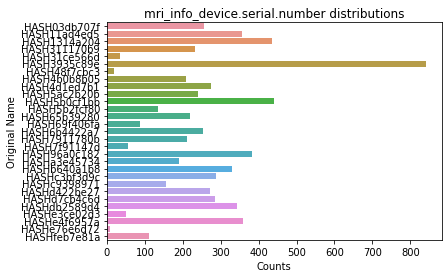

In [ ]:
ML.Show_Targets_Dist()

Thats a bunch of sites right there. Importantly this is not going to be our explicit problem formulation. What we are actually going to set up is predicting between different unique scanners, but only within scanners of the same scanner type ('mri_info_manufacturer'). We will load in this information later, but for now, lets just drop some of the scanners with a really small amount of data.

cleared targets.

Loading /mnt/sdb2/ABCD2p0NDA/abcd_mri01.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 0 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

loading: mri_info_device.serial.number
Dropping ['HASH31ce566d' 'HASH48f7cbc3' 'HASH69f406fa' 'HASH7f91147d'
 'HASHc9398971' 'HASHe3ce02d3' 'HASHe76e6d72'] according to passed drop percent of 0.02

Dropped 760 rows based on filter input params, e.g. filter outlier percent, drop cat, ect...
Final shape:  (10995, 1)

Total valid overlapping subjects = 6665

All loaded targets
0 : mri_info_device.serial.number

Set to overlapping loaded subjects.
-- mri_info_device.serial.number --


,Original Name,Counts,Frequency
Internal Name,,,
0.0,HASH03db707f,256,0.038410
1.0,HASH11ad4ed5,357,0.053563
2.0,HASH1314a204,436,0.065416
3.0,HASH311170b9,233,0.034959
4.0,HASH3935c89e,841,0.126182
5.0,HASH4b0b8b05,209,0.031358
6.0,HASH4d1ed7b1,275,0.041260
7.0,HASH5ac2b20b,239,0.035859
8.0,HASH5b0cf1bb,441,0.066167


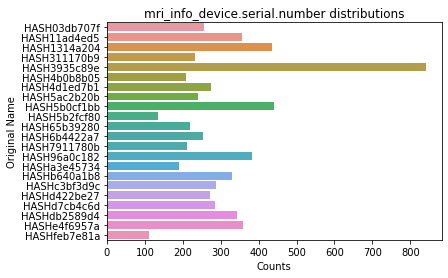

In [ ]:
ML.Load_Targets(loc = target1,
                col_name = 'mri_info_deviceserialnumber',
                data_type = 'c',
                categorical_drop_percent = .02,
                clear_existing=True)

ML.Show_Targets_Dist()

### -- Brief advanced usage aside, customizing plotting! --

Let's take a quick break from all this loading, and discuss quickly how one might further customize any of the auto-magically generated plots. First of all, most of the plotting functions have a number of other potential user defined arguments, let's look at those first, and then how you could further take complete control.

In [ ]:
help(ML.Show_Targets_Dist)

Help on method Show_Targets_Dist in module ABCD_ML.main._Plotting:

Show_Targets_Dist(targets='SHOW_ALL', cat_show_original_name=True, show_only_overlap=True, subjects=None, show=True) method of ABCD_ML.main.ABCD_ML.ABCD_ML instance
    This method displays some summary statistics about
    the loaded targets, as well as plots the distibution if possible.
    
    Parameters
    ----------
    targets : str, int or list, optional
        The single (str) or multiple targets (list),
        in which to display the distributions of. The str input
        'SHOW_ALL' is reserved, and set to default, for showing
        the distributions of loaded targets.
    
        You can also pass the int index of the loaded target to show!
    
        (default = 'SHOW_ALL')
    
    cat_show_original_name : bool, optional
        If True, then when showing a categorical distribution (or binary)
        make the distr plot using the original names. Otherwise,
        use the internally used names.
  

The important params here to note are, if we set cat_show_original_name to False, then the y-axis with our labels with show targets_1, targets_2 ect... instead of the original site name. 

Also, note there is a slight discrepency between the final loaded shape, (6369, 9),
and the number of subjects after computing the overlap with loaded Data and Covars of 6222. By default the function plots and shows info for only those 6222, but if we wanted to see it for the 6369, we would set show_only_overlap to False.

Lastly, we have show, which we need to set to False if we want to do some more advanced plotting. Let's see what the first two params do first, then move onto that.

-- mri_info_device.serial.number --


,Counts,Frequency
Internal Name,,
0.0,444,0.040382
1.0,510,0.046385
2.0,550,0.050023
3.0,377,0.034288
4.0,1010,0.091860
5.0,455,0.041382
6.0,431,0.039200
7.0,542,0.049295
8.0,631,0.057390


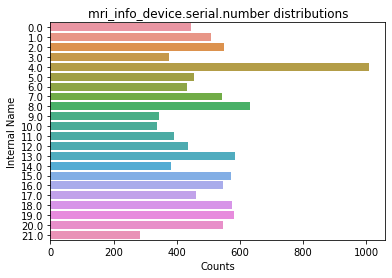

In [ ]:
ML.Show_Targets_Dist(targets = 'mri_info_deviceserialnumber',
                     cat_show_original_name=False,
                     show_only_overlap=False)

Then, for much more customization, turn show off. This way we can interact directly with the matplot lib object.

Set to overlapping loaded subjects.
-- mri_info_device.serial.number --


,Original Name,Counts,Frequency
Internal Name,,,
0.0,HASH03db707f,256,0.038410
1.0,HASH11ad4ed5,357,0.053563
2.0,HASH1314a204,436,0.065416
3.0,HASH311170b9,233,0.034959
4.0,HASH3935c89e,841,0.126182
5.0,HASH4b0b8b05,209,0.031358
6.0,HASH4d1ed7b1,275,0.041260
7.0,HASH5ac2b20b,239,0.035859
8.0,HASH5b0cf1bb,441,0.066167


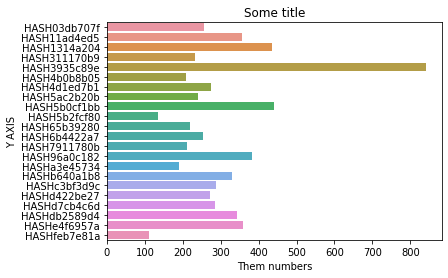

In [ ]:
ML.Show_Targets_Dist(targets = 'mri_info_deviceserialnumber', show=False)
plt.title('Some title')
plt.xlabel('Them numbers')
plt.ylabel('Y AXIS')
# any other matplotlib ~~~
plt.show()

Support for passing in figures / ax directly will most likely be added in the future, but for now are not supported. If one would like to incorperate this type of plot into a multi-figure they will for now have to implement the plotting themselves. 

### -- fin --

Alright great, we now have now have still 7k subjects with data and all target variables!


On to loading Covars, well, name used roughly. These are just features which tend to come in more different types of data, and should potentially be pre-processed differently - In the end, they within the context of this framework, will just be passed as input along with the loaded neuroimaging ROI data.

There are a number of options when loading covars, for example, on how to encode categorical variables (as ordinal, dummy coded or one-hot encoded), Be careful with choices made, just because something is an option does not mean it is the right option. Notably during modelling there are a number of options, for example to apply scalers to just loaded co-variates, or to run model evaluations with covariates included or excluded.

We will just load in interview_age.

In [ ]:
ML.Load_Covars(loc = struc1,
               col_name = 'interview_age',
               data_type = 'f')

Loading /mnt/sdb2/ABCDFixRelease2p0p1/abcd_mrisdp101.txt  with dataset type: basic
Dropped 0 cols for all missing values
Loaded rows with NaN remaining: 0
loading: interview_age
loaded shape:  (11534, 1)

Total valid overlapping subjects = 6665



Like targets, there is a special function built in for viewing covar distributions, either for all loaded (by default), or if there are a lot being used, a specific covar feature can be examined!

Set to overlapping loaded subjects.
-- interview_age --


,interview_age
count,6665.000000
mean,119.380195
std,7.536571
min,107.000000
25%,113.000000
50%,119.000000
75%,126.000000
max,132.000000


Num. of unique vals: 26



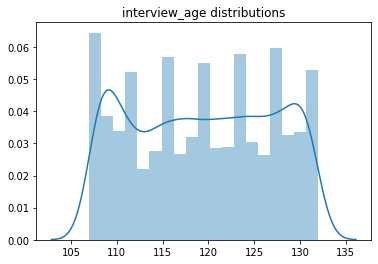

In [ ]:
ML.Show_Covars_Dist()

This distribution seem fine, no big outliers or anything.

The Loading phase is just about complete. We still need to load in our scanner type / manufactorer information though! We do this through Load_Strat(), which is for loading special stratification values. These are useful if we were intrested in defining some sort of complex cross validation behavior, for example, retaining subjects with the same family id within the same train/test fold. They can also be used to restrict analysis to just one scanner type at a time, as we will see (or they could be used during Evaluate for other behvaior, such a resampling or performing left-out CV, there are a ton of options!). 

Let's load in scanner manufactorer now.

Loading /mnt/sdb2/ABCD2p0NDA/abcd_mri01.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 0 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

Total valid overlapping subjects = 6665

Set to overlapping loaded subjects.
-- mri_info_manufacturer_Strat --


,Original Name,Counts,Frequency
Internal Name,,,
0,GE MEDICAL SYSTEMS,1216,0.182446
1,Philips Medical Systems,836,0.125431
2,SIEMENS,4613,0.692123


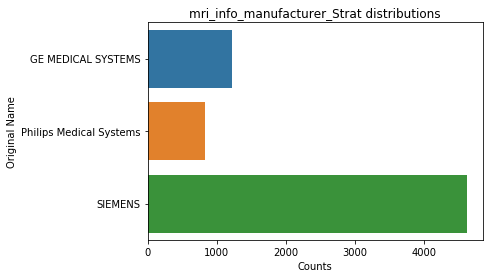

In [ ]:
ML.Load_Strat(loc = target1,
              col_name = 'mri_info_manufacturer')

ML.Show_Strat_Dist()

Let's actually explicitly drop the Philip's scanners, as we don't have a lot of subjects, and realistically we might not have enough for GE, but we'll keep it for now.

cleared strat.

Loading /mnt/sdb2/ABCD2p0NDA/abcd_mri01.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 0 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0
Dropping ['Philips Medical Systems'] according to passed drop percent of 0.15
Dropped 1513 rows based on filter input params, e.g. filter outlier percent, drop cat, ect...

Total valid overlapping subjects = 5829

Set to overlapping loaded subjects.
-- mri_info_manufacturer_Strat --


,Original Name,Counts,Frequency
Internal Name,,,
0.0,GE MEDICAL SYSTEMS,1216,0.208612
1.0,SIEMENS,4613,0.791388


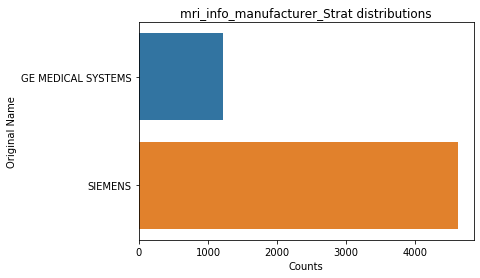

In [ ]:
ML.Load_Strat(loc = target1,
              col_name = 'mri_info_manufacturer',
              categorical_drop_percent = .15,
              clear_existing = True)

ML.Show_Strat_Dist()

And we are done, we have loaded all of the data we will need to complete our expiriment, let's move on!

# Validation Phase

As briefly mentioned just before this, you can define special CV behavior which will be enforced across the main train/test split, and every internal train/validation split (for hyperparam tuning, ect...). The options here are:
Defining 'groups' which will ensure everyone with the same groups value remains in the same fold, or defining 'stratify' which will try to balance the distribution of stratify values between the train and test fold. 

In addition to either choosing one or neither of those, you can specify train_only subjects. Which will force certain subjects to always be placed within the training fold. For example, this behavior might be useful if you were worried about generating test statistics from subjects with missing data, but still wanted to if possible leverage their data during training. Or for example if you were unsure on if you should include some data based on a QC metric. In this case, you could specify those dubious subjects as train_only, and then during Evaluate, you could either include them, or not, and compare model performance to quickly see if they provide any benefit. 

We will define stratifying behavior over our target variable, unique scanner, and therefore ensure that each instance of train, test and validation folds will have roughly the same distribution of subjects from each site!

In [ ]:
ML.Define_Validation_Strategy(stratify='mri_info_device.serial.number')


Total valid overlapping subjects = 5829
Removing non overlapping subjects from loaded data, covars, ect...

CV defined with stratifying behavior over 19 unique values.


,mri_info_device.serial.number,Counts
0,HASH03db707f,256
1,HASH11ad4ed5,357
2,HASH65b39280,220
3,HASH7911780b,211
4,HASH96a0c182,382
5,HASHa3e45734,189
6,HASHb640a1b8,330
7,HASHc3bf3d9c,287
8,HASHd422be27,273
9,HASHd7cb4c6d,285


Next, we will reserve 20% of the data as a test set. Importantly this will take into account the stratify behavior we defined, ensuring all unique scanners have representation in our testing set!

In [ ]:
ML.Train_Test_Split(test_size=.2)

Preparing final data, in self.all_data
Any changes to loaded data, covars or strat will not be included, from now on.

Final data (w/ target) for modeling loaded shape: (5829, 4999)
Performing split on 5829 subjects!
Test split size: 0.2

Performed train test split!
Train size: 4663
Test size:  1166


# Modelling Phase

The different data we have loaded breaks down according to unique key as follows

In [ ]:
smri_names =\
['smri_',
'smri_thick_cort',
'smri_sulc_cort',
'smri_area_cort',
'smri_t1w.contrast_cort',
'smri_t1w.gray02_cort',
'smri_t1w.white02_cort',
'smri_vol_cort']

nback_names =\
['tfmri_nback_all_',
'tfmri_nback_all_0.back_beta',
'tfmri_nback_all_2.back_beta',
'tfmri_nback_all_place_beta',
'tfmri_nback_all_emotion_beta',
'tfmri_nback_all_2.back.vs.0.back_beta',
'tfmri_nback_all_face.vs.place_beta',
'tfmri_nback_all_emotion.vs.neutface_beta',
'tfmri_nback_all_negface.vs.neutface_beta',
'tfmri_nback_all_posface.vs.neutface_beta']

mid_names =\
['tfmri_mid_all_',
 'tfmri_mid_all_antic.reward.vs.neutral_beta',
 'tfmri_mid_all_antic.loss.vs.neutral_beta',
 'tfmri_mid_all_reward.pos.vs.neg.feedback_beta',
 'tfmri_mid_all_loss.pos.vs.neg.feedback_beta',
 'tfmri_mid_all_antic.large.reward.vs.neutral_beta',
 'tfmri_mid_all_antic.small.reward.vs.neutral_beta',
 'tfmri_mid_all_antic.large.vs.small.reward_beta',
 'tfmri_mid_all_antic.large.loss.vs.neutral_beta',
 'tfmri_mid_all_antic.large.vs.small.loss_beta',
 'tfmri_mid_all_antic.small.loss.vs.neutral_beta']

sst_names =\
['tfmri_sst_all_',
 'tfmri_sst_all_correct.go.vs.fixation_beta',
 'tfmri_sst_all_correct.stop.vs.correct.go_beta',
 'tfmri_sst_all_incorrect.stop.vs.correct.go_beta',
 'tfmri_sst_all_any.stop.vs.correct.go_beta',
 'tfmri_sst_all_correct.stop.vs.incorrect.stop_beta',
 'tfmri_sst_all_incorrect.go.vs.correct.go_beta',
 'tfmri_sst_all_incorrect.go.vs.incorrect.stop_beta']

rs_names = ['rsfmri_cor_network.gordon']
all_names = [smri_names, nback_names, mid_names, sst_names, rs_names]

The basic idea in this stage is to investigate different model pipelines, and choices of params on the training set. 

There are a lot of different options, and all sort of jammed into one function which can be a bit intimidating. To ease this, we can use Set_Default_ML_Params to set default values for all of the params used during the actual call to Evaluate, that we don't think we will be changing. All parameters accepted by Evaluate can be set as a default, and likewise, can be overriden when calling Evaluate just by passing a value.

In [ ]:
#ML.Set_Default_ML_Params?

In [ ]:
# Any params left out we just want as default
ML.Set_Default_ML_Params(problem_type = 'categorical',
                         metric = ['matthews', 'macro f1'],
                         scaler = 'robust',
                         scaler_scope = 'all',
                         splits = 3,
                         n_repeats = 3,
                         search_splits = 3,
                         n_jobs = 8,
                         search_n_iter = 100)

No default target passed, set to 0.
No default model type passed, set to linear.
No default imputer passed, set to [mean, median]
No default imputer scope passed, set to [float, categorical]
No default sampler passed, set to None
No default sample on passed, set to targets
No default feat selector passed, set to None
No default ensemble type passed, set to basic ensemble
No default ensemble split passed, set to .2
No default search type passed, set to None
No default model param ind passed, set to 0
No default imputer scaler params passed, set to 0
No default data scaler params passed, set to 0
No default sampler params passed, set to 0
No default feat selector params passed, set to 0
No default ensemble type params passed, set to 0
No default feats_to_use passed, set to all
No default subjects_to_use passed, set to all
No default compute_train_score passed, set to False
No default random state passed, using class random state value of 1
No default feat_importances passed, set to base


We will also start by setting subjects_to_use in order to specify using only the Siemans sites first, and setting the input data to only the resting state data (as a start to mess around with some different models, and as resting state has the least number of features, we can quickly explore some different options). 

In [ ]:
ML.Set_Default_ML_Params(subjects_to_use = ('mri_info_manufacturer', 1),
                         feats_to_use = 'rsfmri_cor_network.gordon')

Default ML params set within self.default_ML_params.


As if those were not enough parameters for you... (but really, for the most part, you can leave most the ones above  as default, as they tend to add additional behavior),

There are some optional extra levels of verbosity during modelling to toggle True/False, as on/off.
We'll just them to default.

In [ ]:
ML.Set_Default_ML_Verbosity()

No default progress bar passed, set to True.
No default fold name passed, set to False.
No default time per fold passed, set to False.
No default score per fold passed, set to False.
No default fold sizes passed, set to False.
No default save to logs passed, set to False.



To start, let's explore using a light gbm, but run an expiriment to see if there is a search type which might work better than just a random search.

In [ ]:
ML.verbose = False  # Temp turn off

search_types = ['RandomSearch', 'HaltonSearch', 'HammersleySearch',
                'TwoPointsDE', 'PortfolioNoisyDiscreteOnePlusOne',
                'FastGANoisyDiscreteOnePlusOne', 'LHSSearch']

for search_type in search_types:
    print(search_type)
    _ = ML.Evaluate(run_name = 'lgbm_' + search_type,
                    model = "light gbm",
                    model_params = 1,
                    search_type = search_type)

RandomSearch


HaltonSearch


HammersleySearch


In [ ]:
print('Matthews')
for name in ML.eval_scores:
    print(name + ': ', ML.eval_scores[name]['Validation']['matthews']['Mean'])

print()

print('Macro F1')
for name in ML.eval_scores:
    print(name + ': ', ML.eval_scores[name]['Validation']['macro f1']['Mean'])

Alright, there does not appear to be huge differences in score between the different search methods, but both HammersleySearch and PortfolioNoisyDiscreteOnePlusOne did the best (depending on the metric).

In [ ]:
ML.verbose = True

scores, raw_preds, FIs = ML.Evaluate(run_name = 'lgbm_big_pipeline_test',
                                     model = "light gbm",
                                     model_params = 1,
                                     scaler = 'robust',
                                     scaler_params = 1,
                                     search_type = 'PortfolioNoisyDiscreteOnePlusOne')

As stated, there are a number of different choices we can play with:

- Type of model:
    
    This includes the actual model, e.g. logistic or elastic net, as well as different model_params, with  a grid or a random search for different hyper-parameters.


- Metrics:
    
    We have already defined 3 metrics to see the output of, but especially with a multiclass problem it might be useful to see by class metrics, or some other type. It always useful to examine multiple metrics to truly understand model performance.
    
    
- Choice of imputer:
    
    Right now, we are simply using the default settings for missing data imputation, which just involves mean imputation for float data and median for categorical. With imputer, imputer_scope and imputer_params you can set up more sophisticated strategies.
    
    
- Different scaling option:
    
    Rather then simply using the robust scaler on all of the data, we can optionally apply different types of scalers, or even a sequence of scalers, or add in hyperparameters to search over with scaler_params. In general scaling is an often over-looked step, but in same cases can improve performance.
    
    
- Resampling our data during training
    
    With the provided sampler, sample_on and sampler_params options, we can play with a number of resampling, both under and oversampling, designed to help combat class imbalanced. These range from simple techniques like randomly oversampling minority classes and undersampling majority classes, to creating synthetic data points. We can also sample on not just target varaible imbalances, but any variable loaded in strat (or a combination). For example, if we loaded race information into strat, we could resample such that under-represented races were given equal representation when training the classifier - there is a whole realm of possibilities to explore here!
    
    
- Front-end feature selection
    
    A potentially useful strategy for working with a large number of features is to perform some sort of feature selection. The parameters provided in feat_selector and feat_selector_params let us try a few different options here, and can be easily added into the hyperparameter search space.
    

- Ensembles of models: 
    
    Simmilar to model type, we can explore ensembles of models with ensemble and ensemble_params, allowing for anything from just averaging the predictions from a list of models, to creating an ensemble via bagging on a single classifier (all the way to fitting meta estimator's with another left out portion of the data).
    
    
The above represent most of the actual "modelling itself", or nuts and bolts of the model pipeline that you can put together, but there are more things you can try, such as creating male only or female only classifiers, or if this were not an example focusing on scanner, you could run a leave-out-site or scanner CV.